# Helmholtz 1D: Ideal TV & Coarsening for Estimating Relaxation Smoothing

## Goal
Coarrsen 1D Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with constant k using repetitive coarsening.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. 

In this experiment we use a fixed periodic domain with $n=96$ points and a small various $kh$ values. We use the idealized test functions = lowest eigenvectors of $A^h$.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

## Level 0->1 Coarsening
* For various $kh$ values:
* Idealized TV = 2 lowest Eigenvectors.
* Using 10 samples (windows) from each vector.

In [41]:
# Fixed seed for reproducible results.
np.random.seed(0)

n = 96
num_examples = 2
num_windows = 10
threshold = 0.1

kh_values = np.array([0, 0.25, 0.5, 0.7, 1, 2**0.5, 2])
# Exactly 12 gridpoints per wavelength.
#kh = 0.52338538
# Aggregate size must evenly divide the domain size.
aggregate_size_values = np.array([2, 4, 6, 8], dtype=int)
# Mock cycle #relaxations per cycle.
nu_values = np.arange(1, 12, dtype=int)

In [42]:
def ideal_tv(a, num_examples):
    """Returns a test matrix of the 'num_examples' lowest eigenvectors of a and an array of the
    corresponding eigenvalues.
    
    Note: scipy may return complex eigenvectors, but a symmetric matrix always has orthogonal real
    eigenvectors. See https://math.stackexchange.com/questions/47764/can-a-real-symmetric-matrix-have-complex-eigenvectors
    for explanation. 𝐴(𝑎+𝑖𝑏)=𝜆(𝑎+𝑖𝑏)⇒𝐴𝑎=𝜆𝑎  and 𝐴𝑏=𝜆𝑏. Thus we return the real part of v here."""
    lam, v = eig(a.todense())
    lam = np.real(lam)
    v = np.real(v)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    return v[:, :num_examples], lam


def create_coarsening(a, x, num_windows, aggregate_size):
    """Returns a coarsening of a repetitive Helmholtz problem a from windows of the test matrix x."""
    return hm.setup.coarsening.create_coarsening(
        np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                                     for offset in range(num_windows)), axis=1).transpose(), 
                threshold)


def mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values):
    """Returns a matrix of mock cycle convergence factors (agg size x nu)."""
    return np.array([
        np.array([hm.setup.auto_setup.mock_cycle_conv_factor(
            level, 
            create_coarsening(a, x, num_windows, aggregate_size)[0].tile(level.a.shape[0] // aggregate_size),
            nu) for nu in nu_values])
            for aggregate_size in aggregate_size_values
    ])

def plot_coarsening_result(result):
    kh_values = result.keys()
    fig, axs = plt.subplots(len(kh_values), 5, figsize=(16, 3 * len(kh_values)))
    for row, kh in enumerate(kh_values):
        info = result[kh]
        x, lam, level, mock_conv, nc, aggregate_size, r, s = \
            info["x"], info["lam"], info["level"], info["mock_conv"], info["nc"], info["aggregate_size"], \
            info["r"], info["s"]

        ax = axs[row, 0]
        ax.plot(lam[:20], "rx")
        ax.grid(True)
        ax.set_xlabel("i")
        ax.set_title(r"Eigenvalues $\lambda_i$");
        ax.set_ylabel("kh {:.2f}".format(kh))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        ax.set_title("Test Functions")
        for i, xi in enumerate(x.transpose()):
            ax.plot(xi, label=r"$\lambda = {:.2e}$".format(lam[i]))
        ax.grid(True);

        # R should be real-valued, but cast just in case.
        ax = axs[row, 2]
        for i, ri in enumerate(np.real(r.asarray())):
            ax.plot(ri)
        ax.set_title("R rows, |Agg| {}".format(aggregate_size))
        ax.grid(True);

        ax = axs[row, 3]
        ax.plot(aggregate_size_values, nc / aggregate_size_values, 'o-')
        ax.grid(True);
        ax.set_title("Coarsening Rat. nc {}".format(np.array2string(nc)));
        ax.set_ylabel("CR")
        ax.set_xlabel("Aggregate Size")

        ax = axs[row, 4]
        for aggregate_size, conv in zip(aggregate_size_values, mock_conv):
            ax.plot(nu_values, conv, label="Agg {}".format(aggregate_size))
        ax.legend(loc="upper right");
        ax.set_ylim([0, 1])
        ax.grid(True);
        ax.set_ylabel("Conv Factor")
        ax.set_xlabel(r"$\nu$")
        ax.set_title("Mock Cycle Conv Factor");

In [43]:
result = collections.OrderedDict()
for kh in kh_values:
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

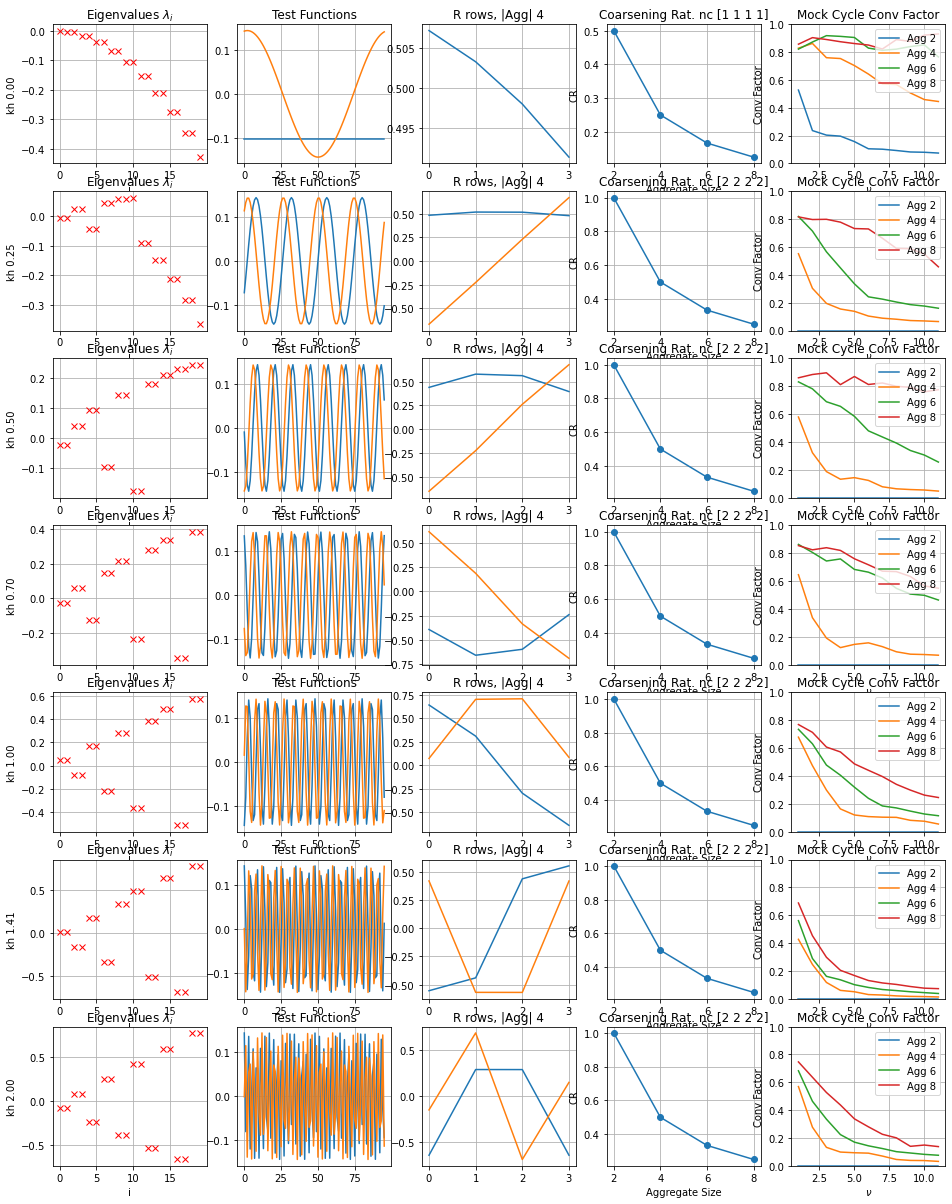

In [44]:
plot_coarsening_result(result)

Looks like the transitional value $kh = 0.5$ poses the largest difficulty (Kaczmarz smoothing is least efficient there), although for aggregate size = 4 (only!) we get a good result there too.

### Example of Intepreting the Coarse Equations for $kh = 0.5$
Interpret the equation via rotation = diagonalization of central block.

In [55]:
kh = 0.5
aggregate_size = 4

a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x, lam = ideal_tv(a, num_examples)
print(x.shape)

r, s = create_coarsening(a, x, num_windows, aggregate_size)
r_csr = r.tile(a.shape[0] // aggregate_size)
#p_csr = r_csr.transpose()

num_windows = 10
x_disjoint_aggregate_t = np.concatenate(tuple(hm.linalg.get_window(x, aggregate_size * offset, aggregate_size)
                                              for offset in range(num_windows)), axis=1).transpose()
num_coarse_vars = nc * num_aggregates
xc = r_csr.dot(x)
xc_disjoint_aggregate_t = np.concatenate(tuple(hm.linalg.get_window(xc, offset, num_coarse_vars)
                                               for offset in range(num_windows)), axis=1).transpose()
p = hm.setup.interpolation.create_interpolation("ls",
                                                r.asarray(), x_disjoint_aggregate_t, xc_disjoint_aggregate_t,
                                          a.shape[0], nc, caliber)

multilevel = hm.hierarchy.multilevel.Multilevel(level)
coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
multilevel.level.append(coarse_level)

(96, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [46]:
print("Fine-level stencil")
print(np.array(level.a.todense()[4:6, 2:8]))
print("SVD Coarsening")
print(s)
print(r.asarray())

ac = coarse_level.a
#print(ac[0].nonzero(), ac[0].data)
print("Coarse-level stencil")
b = np.array(ac[4:6, 2:8].todense())
print(b)
rot = eig(b[:, 2:4])[1]
print("Central block rotation")
print(rot)
print("Is it a rotation? {}".format(norm(rot.dot(rot.transpose()) - np.eye(rot.shape[0])) < 1e-12))
b0, b1, b2 = (rot.transpose().dot(b[:, :2])).dot(rot), (rot.transpose().dot(b[:, 2:4])).dot(rot), (rot.transpose().dot(b[:, 4:6])).dot(rot)
print("After diagonalizing the central block")
print(np.concatenate((b0, b1, b2), axis=1))

print("Diagonalization of neighboring block")
l, v = eig(b0)
print("eigenvalues", l)
print("eigenvectors")
print(v)
print("Is it a rotation? {}".format(norm(v.dot(v.transpose()) - np.eye(v.shape[0])) < 1e-12))

Fine-level stencil
[[-0.08  1.33 -2.25  1.33 -0.08  0.  ]
 [ 0.   -0.08  1.33 -2.25  1.33 -0.08]]
SVD Coarsening
[0.77 0.49 0.   0.  ]
[[ 0.44  0.58  0.56  0.4 ]
 [-0.65 -0.22  0.26  0.68]]
Coarse-level stencil
[[ 0.19  0.35 -0.19  0.04  0.19 -0.31]
 [-0.31 -0.56  0.04 -1.49  0.35 -0.56]]
Central block rotation
[[ 1.   -0.03]
 [ 0.03  1.  ]]
Is it a rotation? True
After diagonalizing the central block
[[ 0.19  0.33 -0.19  0.    0.19 -0.33]
 [-0.33 -0.56  0.   -1.49  0.33 -0.56]]
Diagonalization of neighboring block
eigenvalues [-0.  +0.j -0.37+0.j]
eigenvectors
[[ 0.86 -0.51]
 [-0.51  0.86]]
Is it a rotation? False


In [51]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 0, 3).run(x)
y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle,
                                                np.random.random((a.shape[0], )), 20,
                                                print_frequency=1)
y = y.flatten()
print("Conv Factor {:.5f}".format(conv_factor))

INFO         0 |r| 7.38575015e+00 RER 1.24886
INFO         1 |r| 1.67568213e+00 (0.22688) RER 0.67285 (0.53877) 2.49042
INFO         2 |r| 4.55428677e-01 (0.27179) RER 0.61978 (0.92113) 0.73482
INFO         3 |r| 1.38107537e-01 (0.30325) RER 0.68378 (1.10326) 0.20198
INFO         4 |r| 4.62243755e-02 (0.33470) RER 0.63989 (0.93580) 0.07224
INFO         5 |r| 1.50632668e-02 (0.32587) RER 0.64120 (1.00206) 0.02349
INFO         6 |r| 5.10380203e-03 (0.33882) RER 0.65236 (1.01740) 0.00782
INFO         7 |r| 1.76918739e-03 (0.34664) RER 0.63685 (0.97623) 0.00278
INFO         8 |r| 6.28687776e-04 (0.35535) RER 0.63213 (0.99258) 0.00099
INFO         9 |r| 2.29073038e-04 (0.36437) RER 0.62065 (0.98185) 0.00037
INFO        10 |r| 8.42300758e-05 (0.36770) RER 0.60924 (0.98160) 0.00014
INFO        11 |r| 3.15493525e-05 (0.37456) RER 0.59657 (0.97921) 0.00005
INFO        12 |r| 1.19249128e-05 (0.37798) RER 0.58781 (0.98532) 0.00002
INFO        13 |r| 4.53305705e-06 (0.38013) RER 0.58270 (0.99130) 

0.23674272581278416


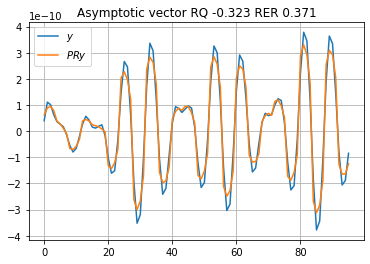

In [33]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
p = coarse_level.p
r = coarse_level.r
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

## Level 1->2 Coarsening
Assuming level 1 was constructed with aggregate size = 4.

In [9]:
result1 = collections.OrderedDict()
for kh in kh_values:
    a = result[kh]["coarse_level"].a
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result1[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

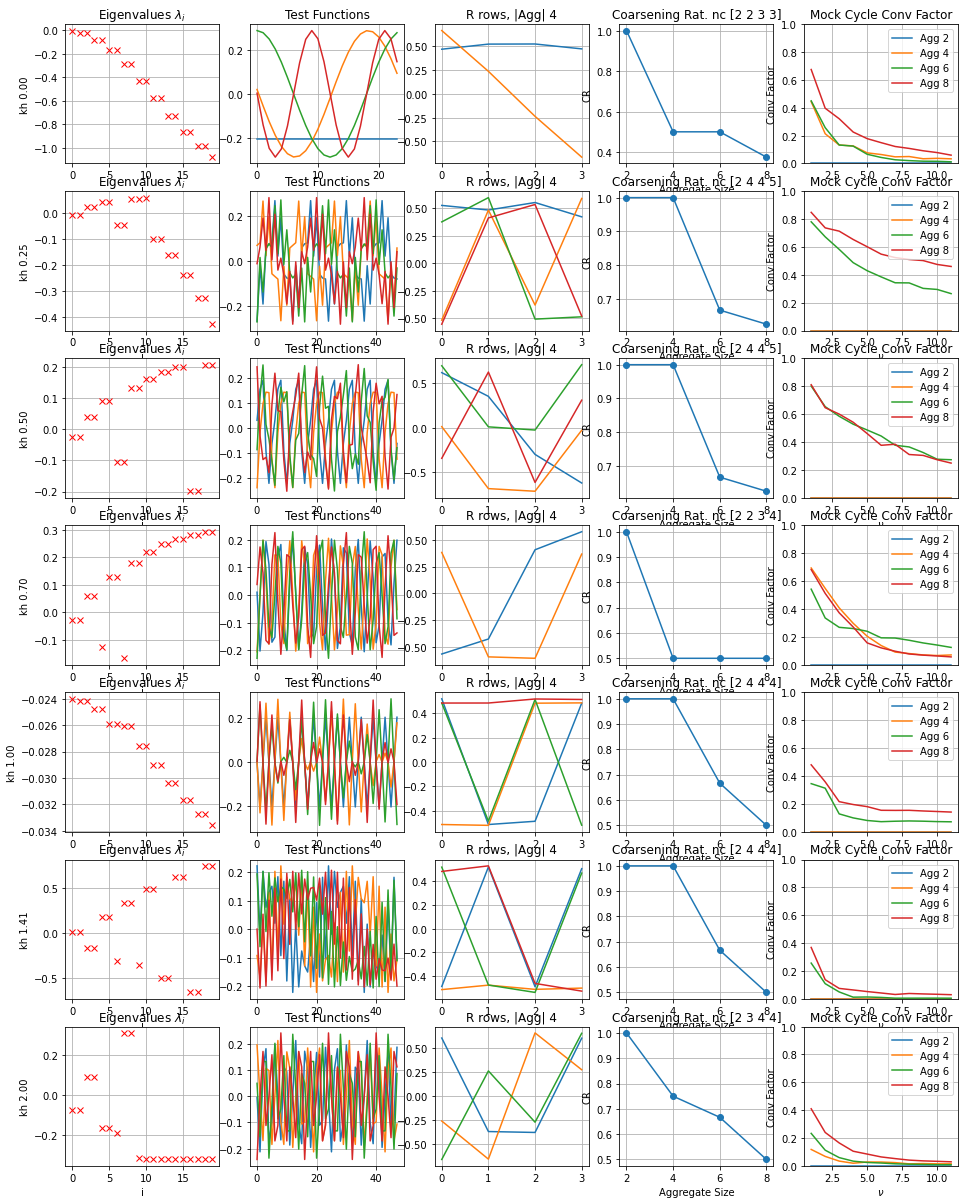

In [10]:
plot_coarsening_result(result1)

## Again, $kh = 0.5$ sees the worst Kaczmarz smoothing. We may be able to improve it with block Gauss-Seidel (see below).

## Effect of Level 0 Aggregate Size on Level 1 Singular Values

In [11]:
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
x, lam = ideal_tv(a, num_examples)
level = hm.setup.hierarchy.create_finest_level(a)
agg_sizes = np.array([2, 4, 8]) # At level 1

for aggregate_size in (4, 6, 8):
    print("Level 0 agg size", aggregate_size)
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)

    ac = coarse_level.a
    xc, lam = ideal_tv(ac, num_examples)
    coarse_level = hm.setup.hierarchy.create_finest_level(ac)
    mock_conv = mock_cycle_conv_factor(level, x, agg_sizes, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    print("Mock cycle convergence Factors")
    print(mock_conv)
    print("Aggregate Sizes", agg_sizes)
    print("nc", nc)

    r, s = create_coarsening(ac, xc, num_windows, 4)
    print(r.asarray(), s)

Level 0 agg size 4
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.58 0.32 0.19 0.13 0.14 0.13 0.08 0.06 0.06 0.06 0.05]
 [0.87 0.87 0.84 0.88 0.8  0.84 0.82 0.81 0.8  0.79 0.77]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[ 0.62  0.35 -0.3  -0.63]
 [ 0.01 -0.69 -0.72 -0.03]
 [ 0.7   0.01 -0.03  0.71]
 [-0.35  0.63 -0.62  0.31]] [1.33 1.09 0.49 0.4 ]
Level 0 agg size 6
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.58 0.32 0.2  0.14 0.14 0.12 0.09 0.06 0.06 0.06 0.05]
 [0.88 0.87 0.85 0.82 0.73 0.84 0.8  0.81 0.8  0.78 0.75]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[-0.53 -0.47  0.45  0.55]
 [ 0.46 -0.54 -0.56  0.44]
 [-0.55 -0.44 -0.45 -0.54]] [1.64 1.49 0.18 0.14]
Level 0 agg size 8
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.56 0.32 0.19 0.14 0.14 0.13 0.09 0.07 0.06 0.06 0.05]
 [0.85 0.91 0.9  0.88 0.86 0.86 0.82 0.75 0.75 0.76 0.77]]
Aggregate Sizes 

Note: we observe Karsten's observation that for aggregate size of 4, there are no clear 2 SVD components at level 1 For size 6, there are just 2 components.

Mock cycle rates are good for any aggregate size at level 0, assuming aggregate size 6 at level 1.

## Comparing Kaczmarz and Block GS Smoothing for Level 1, $kh = 0.5$
Level 1 Formed by Aggregate Size = 4 at Level 0

In [12]:
kh = 0
a0 = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

In [13]:
a = result[kh]["coarse_level"].a
x, lam = ideal_tv(a, num_examples)
coarse_level = hm.setup.hierarchy.create_finest_level(a)
aggregate_size = 6
r, s = create_coarsening(a, x, num_windows, aggregate_size)
print(r.asarray(), s)

[[ 0.36  0.43  0.46  0.45  0.41  0.33]
 [ 0.54  0.38  0.14 -0.14 -0.4  -0.6 ]
 [ 0.6  -0.03 -0.4  -0.4  -0.05  0.56]] [2.8  1.42 0.4  0.05 0.   0.  ]


### Block GS

In [14]:
m = hm.solve.relax.block_tril(a, 2)

In [15]:
m.todense()[:10,:10]

matrix([[-0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58]])

In [16]:
a.todense()[:10,:10]

matrix([[-0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58]])

In [17]:
mock_conv = mock_cycle_conv_factor(coarse_level, x, aggregate_size_values, nu_values)
print(mock_conv)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.45 0.21 0.14 0.13 0.08 0.05 0.05 0.05 0.04 0.04 0.03]
 [0.47 0.24 0.11 0.12 0.06 0.05 0.02 0.02 0.02 0.02 0.01]
 [0.63 0.36 0.32 0.21 0.18 0.14 0.12 0.11 0.09 0.07 0.07]]


In [18]:
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2, omega=1))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, aggregate_size_values, nu_values)
print(mock_conv_bgs)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.21 0.03 0.02 0.01 0.01 0.   0.01 0.   0.   0.   0.  ]
 [0.14 0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.  ]
 [0.22 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.   0.   0.  ]]


Looks like Block GS diverges. Let's check first for Poisson.

### Sanity Check: Block GS Mock Cycle Convergence for Poisson
For aggregate sizes 2, 4, 6, vs. $\nu=1,\dots,5$.

In [19]:
a = hm.linalg.helmholtz_1d_5_point_operator(0.0, n).tocsr()
x, lam = ideal_tv(a, num_examples)

print("Kaczmarz")
level = hm.setup.hierarchy.create_finest_level(a)
print(mock_cycle_conv_factor(level, x, [2, 4, 6], nu_values))

print("GS")
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=1))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
print(mock_conv_bgs)

print("GS, block size 2")
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
print(mock_conv_bgs)

Kaczmarz
[[0.53 0.23 0.2  0.2  0.16 0.1  0.1  0.09 0.08 0.08 0.07]
 [0.87 0.83 0.79 0.77 0.7  0.65 0.62 0.58 0.5  0.48 0.45]
 [0.76 0.69 0.55 0.41 0.27 0.25 0.22 0.2  0.18 0.16 0.16]]
GS
[[0.35 0.14 0.1  0.03 0.03 0.02 0.02 0.01 0.01 0.01 0.01]
 [0.64 0.41 0.22 0.1  0.09 0.08 0.07 0.07 0.07 0.06 0.05]
 [0.48 0.23 0.13 0.08 0.06 0.05 0.04 0.02 0.02 0.01 0.01]]
GS, block size 2
[[0.29 0.15 0.11 0.09 0.08 0.08 0.07 0.07 0.06 0.05 0.05]
 [0.5  0.23 0.13 0.1  0.09 0.07 0.07 0.07 0.06 0.06 0.06]
 [0.39 0.09 0.06 0.04 0.03 0.02 0.02 0.01 0.01 0.01 0.01]]


OK, at least in this case we have BGS reasonable convergence (for aggregate size = 2).

## Relaxation Shrinkage Factor
Shrinkage Factor ~ generalized smoothing factor: the reduction in RER after 10 sweeps, starting from random error.

In [20]:
def print_shrinkage_factor(a, relaxer = None):
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=1)
    b = np.zeros_like(x)
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=relaxer)
    x, relax_conv_factor = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x,num_sweeps=10, print_frequency=1,
        conv_factor_type="rer")
    print("Shrinkage factor {:.3f}".format(relax_conv_factor))
    print("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

### Level 0

In [21]:
# Kaczmarz.
print_shrinkage_factor(a0)

INFO         0 |r| 3.23938567e+00 RER 3.23939
INFO         1 |r| 1.80586237e+00 (0.55747) RER 2.53590 (0.78283) 0.71212
INFO         2 |r| 1.04961846e+00 (0.58123) RER 1.85955 (0.73329) 0.56445
INFO         3 |r| 6.60504735e-01 (0.62928) RER 1.35807 (0.73032) 0.48636
INFO         4 |r| 4.43164812e-01 (0.67095) RER 1.00541 (0.74032) 0.44078
INFO         5 |r| 3.20713227e-01 (0.72369) RER 0.77722 (0.77304) 0.41264
INFO         6 |r| 2.43271077e-01 (0.75853) RER 0.61808 (0.79525) 0.39359
INFO         7 |r| 1.97530464e-01 (0.81198) RER 0.51993 (0.84120) 0.37991
INFO         8 |r| 1.65859049e-01 (0.83966) RER 0.44883 (0.86325) 0.36953
INFO         9 |r| 1.43131547e-01 (0.86297) RER 0.39614 (0.88260) 0.36132
INFO        10 |r| 1.26245108e-01 (0.88202) RER 0.35603 (0.89874) 0.35459
Shrinkage factor 0.855
RER 0.356


In [22]:
# GS is actually great on the fine level.
print_shrinkage_factor(a0, relaxer=hm.solve.relax.GsRelaxer(a0, block_size=1))

INFO         0 |r| 3.48663591e+00 RER 3.48664
INFO         1 |r| 1.35553888e+00 (0.38878) RER 2.36980 (0.67968) 0.57200
INFO         2 |r| 5.48668854e-01 (0.40476) RER 1.30932 (0.55250) 0.41905
INFO         3 |r| 2.29999275e-01 (0.41920) RER 0.64967 (0.49619) 0.35403
INFO         4 |r| 1.10108884e-01 (0.47874) RER 0.34418 (0.52978) 0.31992
INFO         5 |r| 6.36103011e-02 (0.57770) RER 0.21586 (0.62717) 0.29469
INFO         6 |r| 4.28131744e-02 (0.67305) RER 0.15548 (0.72028) 0.27537
INFO         7 |r| 3.26197258e-02 (0.76191) RER 0.12558 (0.80768) 0.25976
INFO         8 |r| 2.62963461e-02 (0.80615) RER 0.10674 (0.84999) 0.24636
INFO         9 |r| 2.19362570e-02 (0.83419) RER 0.09349 (0.87593) 0.23463
INFO        10 |r| 1.88331407e-02 (0.85854) RER 0.08402 (0.89863) 0.22416
Shrinkage factor 0.828
RER 0.084


### Level 1

In [23]:
# Kaczmarz.
print_shrinkage_factor(coarse_level.a)

INFO         0 |r| 6.54694539e-01 RER 0.65469
INFO         1 |r| 3.30949820e-01 (0.50550) RER 0.42128 (0.64348) 0.78558
INFO         2 |r| 1.66472838e-01 (0.50302) RER 0.24393 (0.57903) 0.68245
INFO         3 |r| 1.13036447e-01 (0.67901) RER 0.17924 (0.73478) 0.63065
INFO         4 |r| 8.77985116e-02 (0.77673) RER 0.14762 (0.82361) 0.59475
INFO         5 |r| 7.27380581e-02 (0.82847) RER 0.12827 (0.86890) 0.56707
INFO         6 |r| 6.35363041e-02 (0.87349) RER 0.11665 (0.90942) 0.54467
INFO         7 |r| 5.66017350e-02 (0.89086) RER 0.10761 (0.92252) 0.52597
INFO         8 |r| 5.11443755e-02 (0.90358) RER 0.10028 (0.93180) 0.51004
INFO         9 |r| 4.65960926e-02 (0.91107) RER 0.09388 (0.93625) 0.49632
INFO        10 |r| 4.27298894e-02 (0.91703) RER 0.08821 (0.93956) 0.48442
Shrinkage factor 0.928
RER 0.088


In [24]:
# Block GS.
print_shrinkage_factor(coarse_level.a, relaxer=hm.solve.relax.GsRelaxer(coarse_level.a, block_size=2))

INFO         0 |r| 6.79209497e-01 RER 0.67921
INFO         1 |r| 1.77184732e-01 (0.26087) RER 0.27430 (0.40385) 0.64595
INFO         2 |r| 4.59816443e-02 (0.25951) RER 0.12965 (0.47265) 0.35466
INFO         3 |r| 2.21242615e-02 (0.48115) RER 0.08965 (0.69147) 0.24679
INFO         4 |r| 1.37084522e-02 (0.61961) RER 0.07452 (0.83121) 0.18397
INFO         5 |r| 9.06085673e-03 (0.66097) RER 0.06298 (0.84525) 0.14386
INFO         6 |r| 6.21952060e-03 (0.68642) RER 0.05314 (0.84368) 0.11704
INFO         7 |r| 4.44865649e-03 (0.71527) RER 0.04537 (0.85379) 0.09805
INFO         8 |r| 3.32257070e-03 (0.74687) RER 0.03965 (0.87398) 0.08379
INFO         9 |r| 2.58474975e-03 (0.77794) RER 0.03561 (0.89819) 0.07258
INFO        10 |r| 2.08036593e-03 (0.80486) RER 0.03278 (0.92030) 0.06347
Shrinkage factor 0.878
RER 0.033


In [25]:
# Block GS with under-relaxation.
print_shrinkage_factor(coarse_level.a, relaxer=hm.solve.relax.GsRelaxer(coarse_level.a, block_size=2, omega=0.1))

INFO         0 |r| 6.31369050e-01 RER 0.63137
INFO         1 |r| 5.65073739e-01 (0.89500) RER 0.60059 (0.95125) 0.94086
INFO         2 |r| 5.05825612e-01 (0.89515) RER 0.56759 (0.94506) 0.89118
INFO         3 |r| 4.52879399e-01 (0.89533) RER 0.53312 (0.93927) 0.84949
INFO         4 |r| 4.05568225e-01 (0.89553) RER 0.49795 (0.93403) 0.81447
INFO         5 |r| 3.63295436e-01 (0.89577) RER 0.46281 (0.92942) 0.78499
INFO         6 |r| 3.25527268e-01 (0.89604) RER 0.42832 (0.92548) 0.76002
INFO         7 |r| 2.91786279e-01 (0.89635) RER 0.39500 (0.92221) 0.73871
INFO         8 |r| 2.61645459e-01 (0.89670) RER 0.36323 (0.91957) 0.72034
INFO         9 |r| 2.34722952e-01 (0.89710) RER 0.33327 (0.91752) 0.70431
INFO        10 |r| 2.10677324e-01 (0.89756) RER 0.30527 (0.91599) 0.69014
Shrinkage factor 0.920
RER 0.305


Even a strong under-relaxation GS diverges.

## Strength of Connection (Cosine Similarity)

In [26]:
def print_cosine_similarities(a, aggregate_size: int = 10):
    # Using relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    level = hm.setup.hierarchy.create_finest_level(a)
    x, relax_conv_factor = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x,num_sweeps=10)
    x_relaxed = x

    # Using idealized vectors. Importantly, use more than just the two AZMs, for diversity.
    # Using 10 vectors x 10 windows from each.
    aggregate_size = 10
    x_ideal = ideal_tv(a, 10)[0]

    for title, x in (("Ideal", x_ideal), ("Relaxed", x_relaxed)):
        print("{} vectors".format(title))
        y = np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                             for offset in range(num_windows)), axis=1).transpose()
        y /= norm(y, axis=0)
        cos_distance = np.abs(y.transpose().dot(y))

        print(cos_distance)
        # fig, ax = plt.subplots(figsize=(8, 8))
        # im = ax.imshow(cos_distance, plt.get_cmap("seismic"))

        # # Loop over data dimensions and create text annotations.
        # for i in range(cos_distance.shape[0]):
        #     for j in range(cos_distance.shape[1]):
        #         text = ax.text(j, i, "{:.2f}".format(cos_distance[i, j]),
        #                        ha="center", va="center", color="w")

        # ax.set_title("Level 1 Cosine Similarity")
        # fig.tight_layout()
        # plt.show()

#### Level 0
The correlations decrease like a $cos(kd)$, where $d$ is the distance between points, as Achi calculated. This is seen more clearly in ideal vectors, although relaxed vectos exhibit some of this behavior, espeically for the strongest correlations.

In [27]:
print_cosine_similarities(a0)

Ideal vectors
[[1.   0.98 0.93 0.85 0.75 0.62 0.48 0.34 0.2  0.08]
 [0.98 1.   0.98 0.93 0.85 0.74 0.62 0.48 0.33 0.2 ]
 [0.93 0.98 1.   0.98 0.93 0.85 0.74 0.61 0.47 0.33]
 [0.85 0.93 0.98 1.   0.98 0.93 0.85 0.74 0.61 0.47]
 [0.75 0.85 0.93 0.98 1.   0.98 0.93 0.84 0.73 0.6 ]
 [0.62 0.74 0.85 0.93 0.98 1.   0.98 0.93 0.84 0.73]
 [0.48 0.62 0.74 0.85 0.93 0.98 1.   0.98 0.93 0.84]
 [0.34 0.48 0.61 0.74 0.84 0.93 0.98 1.   0.98 0.93]
 [0.2  0.33 0.47 0.61 0.73 0.84 0.93 0.98 1.   0.98]
 [0.08 0.2  0.33 0.47 0.6  0.73 0.84 0.93 0.98 1.  ]]
Relaxed vectors
[[1.   0.89 0.6  0.24 0.05 0.23 0.32 0.3  0.17 0.08]
 [0.89 1.   0.88 0.57 0.22 0.08 0.28 0.36 0.31 0.13]
 [0.6  0.88 1.   0.88 0.57 0.22 0.07 0.27 0.35 0.27]
 [0.24 0.57 0.88 1.   0.88 0.6  0.27 0.04 0.23 0.3 ]
 [0.05 0.22 0.57 0.88 1.   0.89 0.63 0.29 0.01 0.19]
 [0.23 0.08 0.22 0.6  0.89 1.   0.9  0.62 0.29 0.02]
 [0.32 0.28 0.07 0.27 0.63 0.9  1.   0.89 0.62 0.31]
 [0.3  0.36 0.27 0.04 0.29 0.62 0.89 1.   0.9  0.64]
 [0.17 0.31 0.3

#### Level 1

In [28]:
print_cosine_similarities(coarse_level.a)

Ideal vectors
[[1.   0.74 0.18 0.18 0.15 0.04 0.11 0.02 0.05 0.03]
 [0.74 1.   0.73 0.19 0.16 0.14 0.03 0.1  0.02 0.04]
 [0.18 0.73 1.   0.74 0.19 0.17 0.15 0.04 0.11 0.03]
 [0.18 0.19 0.74 1.   0.73 0.18 0.17 0.14 0.04 0.1 ]
 [0.15 0.16 0.19 0.73 1.   0.73 0.2  0.16 0.15 0.03]
 [0.04 0.14 0.17 0.18 0.73 1.   0.74 0.18 0.18 0.15]
 [0.11 0.03 0.15 0.17 0.2  0.74 1.   0.73 0.18 0.17]
 [0.02 0.1  0.04 0.14 0.16 0.18 0.73 1.   0.74 0.19]
 [0.05 0.02 0.11 0.04 0.15 0.18 0.18 0.74 1.   0.73]
 [0.03 0.04 0.03 0.1  0.03 0.15 0.17 0.19 0.73 1.  ]]
Relaxed vectors
[[1.   0.85 0.48 0.1  0.13 0.12 0.03 0.23 0.41 0.51]
 [0.85 1.   0.85 0.48 0.05 0.2  0.22 0.08 0.15 0.37]
 [0.48 0.85 1.   0.84 0.41 0.03 0.26 0.29 0.15 0.1 ]
 [0.1  0.48 0.84 1.   0.81 0.38 0.   0.23 0.29 0.18]
 [0.13 0.05 0.41 0.81 1.   0.83 0.49 0.14 0.13 0.25]
 [0.12 0.2  0.03 0.38 0.83 1.   0.88 0.6  0.25 0.06]
 [0.03 0.22 0.26 0.   0.49 0.88 1.   0.9  0.62 0.27]
 [0.23 0.08 0.29 0.23 0.14 0.6  0.9  1.   0.9  0.62]
 [0.41 0.15 0.1

Here it is not clear if there are any strong correlations. So how come relaxation converges so slowly? Shouldn't Gauss-Seidel be fast in this case?